###  Challenge compare decision trees and random forests

Now that you've learned about random forests and decision trees let's do an exercise in accuracy. You know that random forests are basically a collection of decision trees. But how do the accuracies of the two models compare?

So here's what you should do. Pick a dataset. It could be one you've worked with before or it could be a new one. Then build the best decision tree you can.

Now try to match that with the simplest random forest you can. For our purposes measure simplicity with runtime. Compare that to the runtime of the decision tree. This is imperfect but just go with it.

Using the Temperature data set from Regression mode module. 

Here are the credentials you can use to connect to the database:


    postgres_user = 'dsbc_student'
    postgres_pw = '7*.8G9QH21'
    postgres_host = '142.93.121.174'
    postgres_port = '5432'
    postgres_db = 'weatherinszeged'

As in earlier assignments, be sure to close the database connection after initially pulling in your data.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import linear_model
import statsmodels.formula.api as smf
from sqlalchemy import create_engine
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import seaborn as sns
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format
import warnings
warnings.filterwarnings(action="ignore")

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'weatherinszeged'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

weather_df = pd.read_sql_query('select * from weatherinszeged',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

weather_df.head(10)

,date,summary,preciptype,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,loudcover,pressure,dailysummary
0,2006-03-31 22:00:00+00:00,Partly Cloudy,rain,9.472,7.389,0.890,14.120,251.000,15.826,0.000,1015.130,Partly cloudy throughout the day.
1,2006-03-31 23:00:00+00:00,Partly Cloudy,rain,9.356,7.228,0.860,14.265,259.000,15.826,0.000,1015.630,Partly cloudy throughout the day.
2,2006-04-01 00:00:00+00:00,Mostly Cloudy,rain,9.378,9.378,0.890,3.928,204.000,14.957,0.000,1015.940,Partly cloudy throughout the day.
3,2006-04-01 01:00:00+00:00,Partly Cloudy,rain,8.289,5.944,0.830,14.104,269.000,15.826,0.000,1016.410,Partly cloudy throughout the day.
4,2006-04-01 02:00:00+00:00,Mostly Cloudy,rain,8.756,6.978,0.830,11.045,259.000,15.826,0.000,1016.510,Partly cloudy throughout the day.
5,2006-04-01 03:00:00+00:00,Partly Cloudy,rain,9.222,7.111,0.850,13.959,258.000,14.957,0.000,1016.660,Partly cloudy throughout the day.
6,2006-04-01 04:00:00+00:00,Partly Cloudy,rain,7.733,5.522,0.950,12.365,259.000,9.982,0.000,1016.720,Partly cloudy throughout the day.
7,2006-04-01 05:00:00+00:00,Partly Cloudy,rain,8.772,6.528,0.890,14.152,260.000,9.982,0.000,1016.840,Partly cloudy throughout the day.
8,2006-04-01 06:00:00+00:00,Partly Cloudy,rain,10.822,10.822,0.820,11.318,259.000,9.982,0.000,1017.370,Partly cloudy throughout the day.
9,2006-04-01 07:00:00+00:00,Partly Cloudy,rain,13.772,13.772,0.720,12.526,279.000,9.982,0.000,1017.220,Partly cloudy throughout the day.


### 1) Explore and clean the data

In [2]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
date                   96453 non-null datetime64[ns, UTC]
summary                96453 non-null object
preciptype             96453 non-null object
temperature            96453 non-null float64
apparenttemperature    96453 non-null float64
humidity               96453 non-null float64
windspeed              96453 non-null float64
windbearing            96453 non-null float64
visibility             96453 non-null float64
loudcover              96453 non-null float64
pressure               96453 non-null float64
dailysummary           96453 non-null object
dtypes: datetime64[ns, UTC](1), float64(8), object(3)
memory usage: 8.8+ MB


In [3]:
#Checking for NaN values
weather_df.isnull().any()

date                   False
summary                False
preciptype             False
temperature            False
apparenttemperature    False
humidity               False
windspeed              False
windbearing            False
visibility             False
loudcover              False
pressure               False
dailysummary           False
dtype: bool

### Explore the dataset

In [4]:
categorical = weather_df.select_dtypes(include=['object'])
for i in categorical:
    column = categorical[i]
    print(i)
    print(column.nunique())

summary
27
preciptype
3
dailysummary
214


In [5]:
#Dropping 'dailysummary' as it has 214 unique values and mostly repeats of 'summary'
weather_df.drop(['dailysummary', 'date', 'windbearing', 'visibility', 'apparenttemperature', 'preciptype'], axis=1, inplace=True)

In [6]:
#Make everything lower case
weather_df['summary']=weather_df['summary'].str.lower()

In [7]:
weather_df['summary'].unique()

array(['partly cloudy', 'mostly cloudy', 'overcast', 'foggy',
       'breezy and mostly cloudy', 'clear', 'breezy and partly cloudy',
       'breezy and overcast', 'humid and mostly cloudy',
       'humid and partly cloudy', 'windy and foggy', 'windy and overcast',
       'breezy and foggy', 'windy and partly cloudy', 'breezy',
       'dry and partly cloudy', 'windy and mostly cloudy',
       'dangerously windy and partly cloudy', 'dry', 'windy',
       'humid and overcast', 'light rain', 'drizzle', 'windy and dry',
       'dry and mostly cloudy', 'breezy and dry', 'rain'], dtype=object)

In [8]:
#Create new column to classify days as either 'rainy', 'clear', 'windy', or 'cloudy'

#First create columns for each classification 
conditions = ['rainy', 'clear', 'windy', 'cloudy']

#Now create the classification and have boolean output set to integer value (1 or 0)
for key in conditions:
    weather_df[str(key)] = weather_df.summary.str.contains('' + str(key) + '', case=True).astype(int)

In [9]:
print('rainy:', weather_df['rainy'].unique())
print('clear:', weather_df['clear'].unique())
print('windy:', weather_df['windy'].unique())
print('cloudy:', weather_df['cloudy'].unique())

rainy: [0]
clear: [0 1]
windy: [0 1]
cloudy: [1 0]


In [10]:
weather_df.tail(25)

,summary,temperature,humidity,windspeed,loudcover,pressure,rainy,clear,windy,cloudy
96428,partly cloudy,18.350,0.770,3.220,0.000,1014.680,0,0,0,1
96429,partly cloudy,17.756,0.810,2.962,0.000,1014.650,0,0,0,1
96430,clear,16.622,0.870,3.429,0.000,1014.560,0,1,0,0
96431,clear,16.144,0.870,3.655,0.000,1014.690,0,1,0,0
96432,clear,15.594,0.870,3.284,0.000,1014.520,0,1,0,0
96433,clear,15.011,0.930,3.204,0.000,1014.370,0,1,0,0
96434,clear,15.017,0.900,2.705,0.000,1014.550,0,1,0,0
96435,clear,13.872,0.930,4.750,0.000,1014.660,0,1,0,0
96436,clear,16.072,0.880,2.785,0.000,1015.250,0,1,0,0
96437,partly cloudy,19.561,0.750,3.719,0.000,1015.280,0,0,0,1


In [12]:
weather_df.shape

(96453, 10)

### 2) Create a decision tree to model wheather conditions will be rainy, cloudy, clear or windy given the features in the model.



In [23]:
#Create the data sets
X = weather_df.drop(['summary', 'cloudy', 'rainy', 'windy'], axis=1)
Y = weather_df['clear']

#Create training and test set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30)


In [24]:
X.shape

(96453, 6)

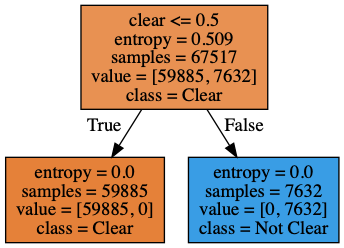

In [25]:
#This is the model we'll be using.
from sklearn import tree
from IPython.display import Image
import pydotplus
import graphviz



# Initialize and train our tree.
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy', min_samples_leaf=1,
    min_samples_split=2)
decision_tree.fit(X_train, y_train)

# Render our tree.
dot_data = tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names=X.columns,
    class_names=['Clear', 'Not Clear'],
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [27]:
y_predict=decision_tree.predict(X_test)

from sklearn.metrics import accuracy_score

print('accuracy score:', accuracy_score(y_test, y_predict))


accuracy score: 1.0
